# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy 

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree # 대문자로 붙어 있는 애들은 클래스임 
from sklearn.metrics import confusion_matrix, classification_report

# Data

레드 와인/화이트 와인 분류

In [2]:
wine_df = pd.read_csv('https://bit.ly/wine-date')

In [3]:
wine_df.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [4]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [5]:
wine_df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [6]:
np.unique(wine_df['class'], return_counts=True)
#> class=0: red wine, class=1: white wine

(array([0., 1.]), array([1599, 4898]))

In [7]:
target_names = ['red', 'white']

In [8]:
# 데이터프레임을 data와 target으로 분리 
X = wine_df.drop(columns='class').to_numpy()   # data
y = wine_df['class'].to_numpy()                # target 

In [9]:
X[:5]

array([[9.4 , 1.9 , 3.51],
       [9.8 , 2.6 , 3.2 ],
       [9.8 , 2.3 , 3.26],
       [9.8 , 1.9 , 3.16],
       [9.4 , 1.9 , 3.51]])

In [10]:
y[:5]

array([0., 0., 0., 0., 0.])

# Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [12]:
X_train.shape, y_train.shape

((5197, 3), (5197,))

In [13]:
y_test.shape, y_test.shape

((1300,), (1300,))

# 모델 훈련 

In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)  # 모델 생성 

In [15]:
tree_clf.fit(X_train, y_train)  # 모델 훈련 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

# 모델 평가

In [16]:
# 훈련 셋 점수 
tree_clf.score(X_train, y_train)

0.9978833942659227

훈련 셋의 정확도: 99.8%

결정 트리(decision tree)모델은 훈련 셋에 과적합(overfitting)되기 쉽다!

In [17]:
# 테스트 셋 점수
tree_clf.score(X_test, y_test)  #> overfitting 

0.8653846153846154

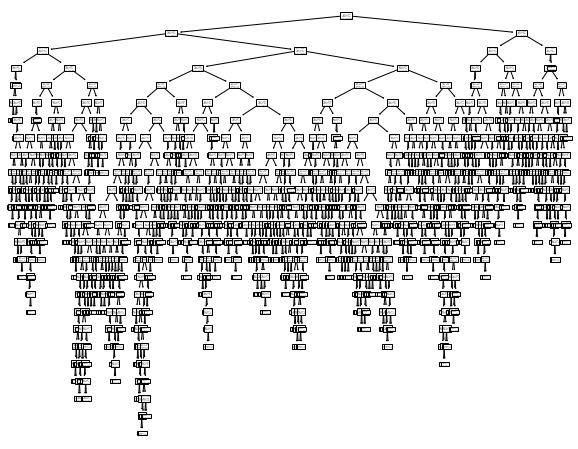

In [18]:
plt.figure(figsize=(10, 8))
plot_tree(tree_clf)
plt.show()

In [19]:
feature_names = ['alcohol', 'sugar', 'ph']
target_names = ['white', 'red']

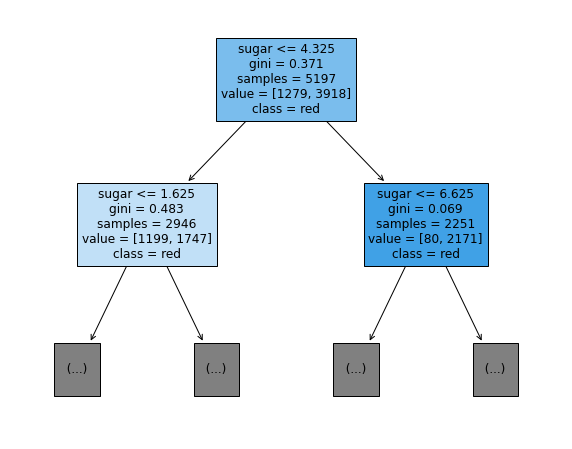

In [20]:
# tree가 너무 복잡하므로, depth=1까지만 시각화 
plt.figure(figsize=(10, 8))
plot_tree(tree_clf, max_depth=1, 
          feature_names=feature_names, 
          class_names=target_names,
          filled=True)
plt.show()

In [21]:
# 이진 분류(binary class)에서 Gini 불순도 계산 방법: 
# Gini impurity(불순도) = 1 - ((음성 클래스의 비율)**2 + (양성 클래스의 비율)**2)
1 - ((1279/5197)**2+(3918/5197)**2)

0.37107315616915937

불순도(impurity):

* 두 클래스가 1:1로 섞여 있으면, 불순도는 최댓값
> 1 - ((1/2)^2 + (1/2)^2) = 0.5

* 클래스가 완벽하게 분리되어 있으면(1:0, 0:1), 불순도는 최솟값 
> 1 - (1^2 + 0) or 1 - (0 + 1^2) = 0

In [22]:
1 - ((1/3**2 + (2/3)**2))

0.4444444444444444

Entrophy(엔트로피) = - ((음성 클래스 비율) x log_2(음성 클래스 비율) + (양성 클래스 비율) x log_2(양성 클래스 비율))

# 규제 파라미터(regularization parameter)

* `max_depth`: decision tree의 최대 깊이

> max_depth가 작아질수록, 규제가 강해서 훈련 셋에서의 점수가 낮아짐. 하지만 훈련 셋에서의 점수가 일반화 점수(테스트 셋에서의 점수)와 비슷할 거라 기대할 수 있음. 즉, 과적합(overfitting)이 작아짐 

> max_depth가 커질수록, 규제가 약해져서 훈련 셋에서의 점수가 높아짐. 이 점수가 일반화 점수와 비슷할 거라고 기대할 수 없음. 즉 과적합(overfitting)이 커짐 

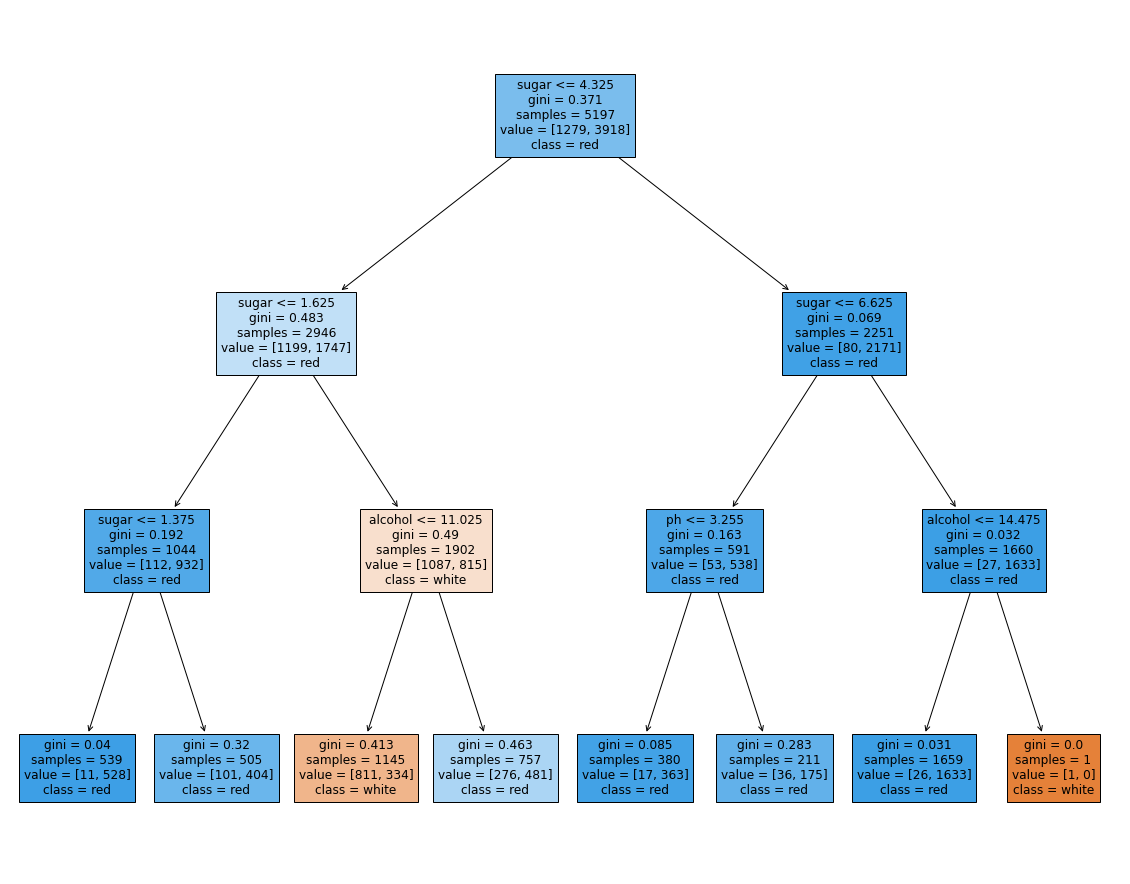

In [23]:
depths = (3, 4, 5, 10, 12, 14, 20)    # 트리의 최대 깊이
train_scores = []     # 각 트리에서 훈련 셋 점수를 저장
test_scores = []      # 각 트리에서 테스트 셋 점수를 저장
for d in depths:      # max_depth 값을 변화시키면서 반복 
    tree_clf = DecisionTreeClassifier(max_depth=d, random_state=42)  # 결정 트리 모델 생성 
    tree_clf.fit(X_train, y_train)  # 모델 훈련 
    tr_sc = tree_clf.score(X_train, y_train)  # 훈련 셋 정확도 
    train_scores.append(tr_sc)
    te_sc = tree_clf.score(X_test, y_test)  # 테스트 셋에서의 정확도 
    test_scores.append(te_sc)

    # max_depth=3인 경우에만 트리 시각화 
    if d == 3:
        plt.figure(figsize=(20, 16))
        plot_tree(tree_clf, feature_names=feature_names, class_names=target_names, filled=True)
        plt.show()

In [24]:
train_scores

[0.8458726188185491,
 0.8595343467385029,
 0.8718491437367712,
 0.9255339619010968,
 0.9538195112564941,
 0.9757552434096595,
 0.9957667885318453]

In [25]:
test_scores

[0.8407692307692308,
 0.8523076923076923,
 0.8576923076923076,
 0.8615384615384616,
 0.8646153846153846,
 0.8661538461538462,
 0.8684615384615385]

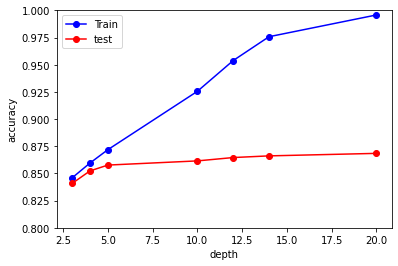

In [26]:
plt.plot(depths, train_scores, 'bo-', label='Train')
plt.plot(depths, test_scores, 'ro-', label='test')
plt.legend()
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.ylim(0.8, 1)
plt.show()

결정 트리의 여러가지 규제 파라미터: 

* `min_samples_split`: 분할되기 위해서 노드가 가져야 하는 샘플의 최소 수(또는 비율)
* `min_samples_leaf`: leaf node가 가지고 있어야 할 샘플의 최소 수(또는 비율) 
* `max_leaf_node`: leaf node의 최대 수
* `max_features`: 각 노드에서 분할(split)에 사용할 특성의 최대 수 

> `min_`으로 시작하는 파라미터들은 값을 증가시키면, 가지가 줄어듦. 규제가 커짐. overfitting이 작아짐 

> `max_`로 시작하는 파라미터들은 값을 감소시키면, 가지가 줄어듦. 규제가 커짐. overfitting 작아짐

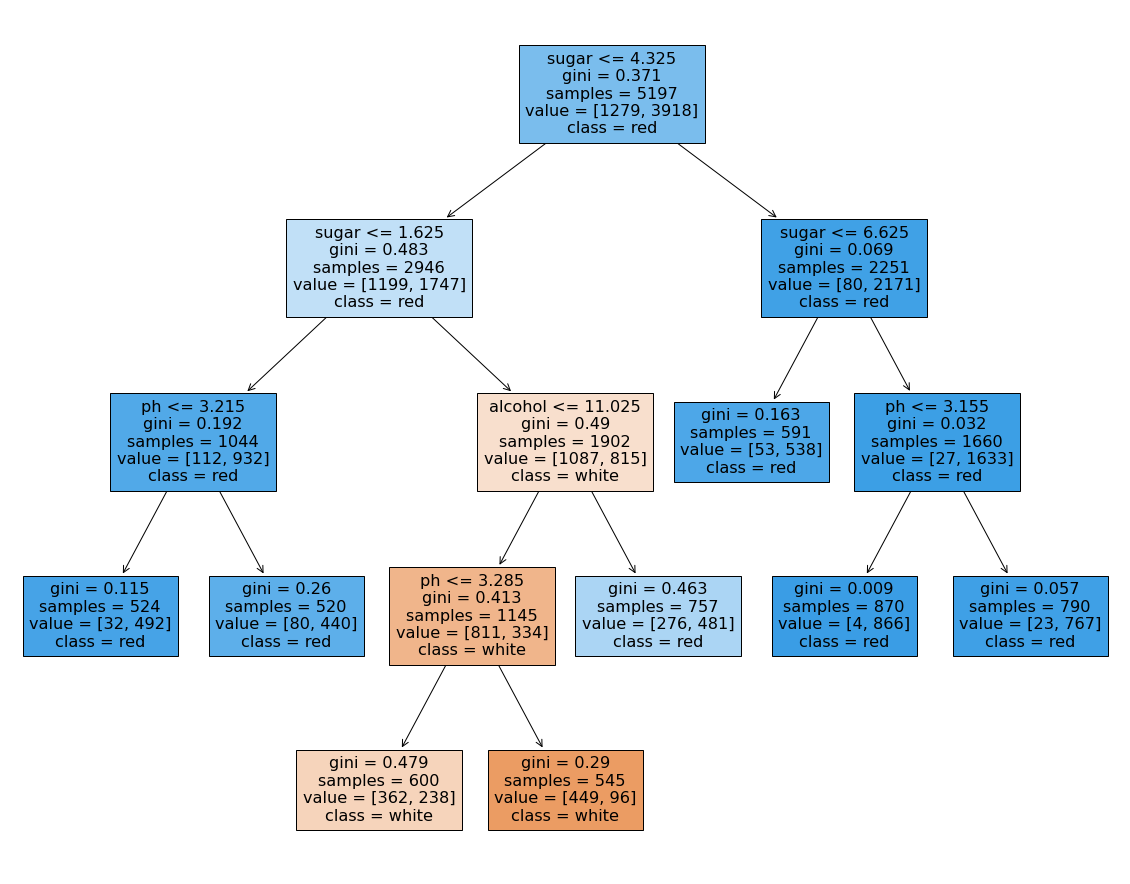

In [27]:
min_samples_leaf = (0.2, 0.1, 0.05, 0.01)
train_scores = []
test_scores = []
for x in min_samples_leaf: 
    tree_clf = DecisionTreeClassifier(min_samples_leaf=x, random_state=42)
    tree_clf.fit(X_train, y_train)
    # 점수 계산, 리스트에 추가 
    train_scores.append(tree_clf.score(X_train, y_train))
    test_scores.append(tree_clf.score(X_test, y_test))


    if x == 0.1:
        plt.figure(figsize=(20, 16))
        plot_tree(tree_clf, feature_names=feature_names, class_names=target_names, filled=True)
        plt.show()

In [28]:
train_scores

[0.8062343659803733,
 0.8456802001154512,
 0.8568404848951318,
 0.8768520300173177]

In [29]:
test_scores

[0.8107692307692308,
 0.8407692307692308,
 0.8476923076923077,
 0.8553846153846154]

In [30]:
for d in depths:
    for x in min_samples_leaf: 
        pass

# 훈련(Train)/검증(Validation)/테스트(Test) 분리

머신 러닝 과정은 훈련 셋으로 모델을 학습(fit)시키고, 테스트 셋으로 평가(일반화 성능 예측)

하이퍼 파라미터(k, alpha, max_depth, ...)를 변화시키면서 그 성능을 테스트 셋으로 평가하게 되면, 테스트 셋에 맞춰지는(fit) 하이퍼 파라미터를 찾게 됨. 즉, 테스트 셋에 맞춰지는 모델이 만들어지게 됨.

이런 경우 테스트 셋의 평가 점수가 일반화 성능이라고 기대하기는 어렵다. 

하이퍼 파라미터를 튜닝할 때는, 훈련 셋을 다시 훈련 셋과 검증 셋으로 나눠서 모델을 (작은) 훈련 셋으로 훈련시키고, 검증 셋의 점수를 사용해서 최적의 하이퍼 파라미터를 찾아

In [31]:
X.shape

(6497, 3)

In [32]:
# (큰) 훈련 셋/테스트 셋 분리
X_train_full, X_test, y_train_full, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [33]:
X_train_full.shape

(5197, 3)

In [34]:
# (작은) 훈련 셋/검증 셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  test_size=0.2, 
                                                  stratify=y_train_full,
                                                  random_state=42)

In [35]:
X_train.shape

(4157, 3)

In [36]:
# hyperparameter max_depth 튜징
train_scores = []
val_scores =[] 
for depth in range(1, 21):
    tree_clf = DecisionTreeClassifier(max_depth=depth)  # 모델 생성
    tree_clf.fit(X_train, y_train)  # 모델 훈련 
    train_scores.append(tree_clf.score(X_train, y_train)) # 훈련 셋 평가
    val_scores.append(tree_clf.score(X_val, y_val))  # 검증 셋(validation set) 평가 

In [37]:
np.around(train_scores, decimals=4)

array([0.7539, 0.827 , 0.8273, 0.8636, 0.8691, 0.8776, 0.8889, 0.899 ,
       0.9112, 0.9298, 0.9478, 0.9581, 0.9714, 0.9798, 0.9863, 0.9911,
       0.9942, 0.9969, 0.9976, 0.9981])

In [38]:
np.around(val_scores, decimals=4)

array([0.7538, 0.8298, 0.8298, 0.8644, 0.875 , 0.8683, 0.8625, 0.8625,
       0.8606, 0.8625, 0.8587, 0.8615, 0.875 , 0.874 , 0.8731, 0.8702,
       0.874 , 0.875 , 0.875 , 0.8712])

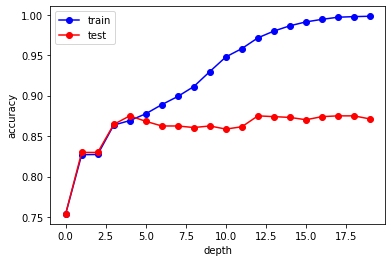

In [39]:
plt.plot(train_scores, 'bo-', label='train')
plt.plot(val_scores, 'ro-', label='test')

plt.legend()
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.show()

In [40]:
# validation score 최댓값, 인덱스 
np.max(val_scores), np.argmax(val_scores)

(0.875, 4)

In [41]:
# 만약 val_score가 최댓값인 max_depth를 선택한다면, 
tree_clf = DecisionTreeClassifier(max_depth=17, random_state=42)
tree_clf.fit(X_train, y_train)
tree_clf.score(X_test, y_test)

0.8569230769230769

일반적으로 테스트 셋의 평가 점수는 검증 셋의 평가 점수보다 약간 낮습니다. 

# 교차 검증(Cross Validation)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y, 
                                                    random_state=42)

In [43]:
X_train.shape, X_test.shape

((5197, 3), (1300, 3))

In [44]:
# 교차 검증에서 사용할 모델 생성
tree_clf = DecisionTreeClassifier(random_state=42)

In [45]:
# 교차 검증 수행
cv = cross_validate(estimator=tree_clf, X=X_train, y=y_train,
                    n_jobs=-1,   
                    return_train_score=True)
# 교차 검증할 때 사용할 CPU 코어(쓰레드) 개수 
# n_jobs=None: 기본값. CPU 코어를 1개 사용
# n_job:-1: 
cv

{'fit_time': array([0.0111773 , 0.01135421, 0.01066828, 0.01073813, 0.01019597]),
 'score_time': array([0.00123405, 0.00103879, 0.00101995, 0.00090861, 0.00099206]),
 'test_score': array([0.86730769, 0.86923077, 0.84696824, 0.85370549, 0.84985563]),
 'train_score': array([0.99807554, 0.99807554, 0.9983165 , 0.998076  , 0.9983165 ])}

In [46]:
cv['test_score']  # 교차 검증에서 검증 셋들의 점수

array([0.86730769, 0.86923077, 0.84696824, 0.85370549, 0.84985563])

In [47]:
np.mean(cv['test_score'])

0.8574135633375286

In [48]:
# 교차 검증에서의 검증 셋 점수만 필요할 때 
cv_score = cross_val_score(tree_clf, X_train, y_train, n_jobs=-1)
cv_score

array([0.86730769, 0.86923077, 0.84696824, 0.85370549, 0.84985563])

In [49]:
# 일반화 성능 계산
tree_clf.fit(X_train, y_train)  # 모델 훈련 
tree_clf.score(X_test, y_test)

0.8653846153846154

# GridSearchCV

In [50]:
X_train.shape, X_test.shape

((5197, 3), (1300, 3))

In [51]:
clf = DecisionTreeClassifier(random_state=42)  # 교차 검증에서 사용할 모델 

In [52]:
# parameter grid: dict 또는 dict들의 list 
# 모델에서 변경할 하이퍼 파라미터 목록. 생성자 함수의 파라미터 이름을 key로 사용
params = {'max_depth': np.arange(1, 21)}

In [53]:
# Grid Search 교차 검증을 할 수 있는 객체 생성 
grid_cv = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1)

In [54]:
# 훈련 셋에 fitting -> 최적의 파라미터 조합을 찾을 수 있음
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9

In [55]:
grid_cv.best_params_  # 최적의 파라미터 조합 

{'max_depth': 5}

In [56]:
grid_cv.best_score_  # 가장 좋은 검증 점수(k-fold CV의 검증 점수 평균)

0.8631863108018065

In [57]:
best_tree = grid_cv.best_estimator_  # 최적의 파라미터로 생성된 최적의 모델
best_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [58]:
# GridSearchCV로 찾은 최적의 모델을 훈련시키고 평가
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [59]:
best_tree.score(X_train, y_train)

0.8718491437367712

In [60]:
best_tree.score(X_test, y_test)

0.8576923076923076

GridSearchCV을 수행
* max_depth: 1 ~ 20 정수
* min_samples_leaf: 2, 12, 22, 32, ... 92, 102
* min_impurity_decrease: 0.0001, 0.001, 0.01 

In [61]:
# parameter grid(파라미터 조합): 20 x 11 x 3 = 660 조합 
params = {'max_depth': np.arange(1, 21),
          'min_samples_leaf': np.arange(2, 1110, 10),
          'min_impurity_decrease': [0.0001, 0.001, 0.01]}

In [62]:
# GridSearchCV 객체 생성
grid_cv = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                       param_grid=params, 
                       n_jobs=-1)

In [63]:
# GridSearchCV 훈련
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='d...
        442,  452,  462,  472,  482,  492,  502,  512,  522,  532,  542,
        552,  562,  572, 

In [64]:
grid_cv.best_params_

{'max_depth': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 12}

In [65]:
grid_cv.best_score_

0.8687665654845634

In [66]:
best_tree = grid_cv.best_estimator_  # 최적의 파라미터로 생성된 최적의 모델
best_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [67]:
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [68]:
best_tree.score(X_train, y_train)

0.8937848758899365

In [69]:
best_tree.score(X_test, y_test)

0.8576923076923076

In [70]:
test_pred = best_tree.predict(X_test)
confusion_matrix(y_test, test_pred)

array([[211, 109],
       [ 76, 904]])

# RandomizedSearchCV

랜덤 서치는 parameter grid(파라미터 값드의 목록, 조합)를 불연속적인 값들의 조합으로 전달하는 것이 아니라, 파라미터들을 난수로 샘플링할 수 있는 **확률 분포 객체**를 전달하는 것 

## 난수 생성

In [71]:
np.random.rand(10) # 0 <= r <= 1 균일 분포의 난수 생성

array([0.30092619, 0.72681278, 0.29458009, 0.12786666, 0.29395756,
       0.81892692, 0.4116745 , 0.60613453, 0.78129249, 0.60556526])

In [72]:
np.random.uniform(0, 10, size=10)

array([1.93456202, 4.19993066, 9.61128903, 8.40822847, 5.25337913,
       7.71339524, 5.93173406, 6.31502731, 5.5198056 , 0.90459686])

In [73]:
np.random.randn(10)

array([ 2.1507038 ,  1.75944335,  1.77093343,  1.11187668,  1.17938462,
        1.01549468, -0.10631542,  0.13540719,  0.36285849, -2.12470018])

In [74]:
np.random.randint(0, 10, size=10)

array([0, 4, 8, 2, 5, 5, 1, 9, 3, 0])

## 확률 분포 함수 

In [75]:
# 확률 분포 함수 - 난수 발생기
uniform_generator = scipy.stats.uniform(0, 1)

In [76]:
uniform_generator.rvs(10)
#> random values

array([0.29311903, 0.94811047, 0.35893937, 0.85039663, 0.51080482,
       0.90640729, 0.44376262, 0.03499111, 0.69151934, 0.53596194])

In [77]:
uniform_generator = scipy.stats.uniform(0, 10)  # generator 객체
uniform_generator.rvs(10)  # 난수 생성 

array([0.37429496, 3.25212709, 2.83936848, 6.02775705, 3.2273342 ,
       4.97558483, 9.64801198, 7.66148861, 7.26195781, 5.48722091])

In [78]:
int_generator = scipy.stats.randint(0, 2) # 0 <= r < 2  정수 난수 발생기
int_generator.rvs(10) 

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 1])

위 내용 정리

np는 난수 값들이고, scipy는 난수 생성기이다. 

## RandomizedSearchCV

In [79]:
params = {
    'max_depth': scipy.stats.randint(1, 50),
    'min_samples_leaf': scipy.stats.randint(2, 100),
    'min_impurity_decrease': scipy.stats.uniform(0.0001, 0.001)
}

In [80]:
rand_cv = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                             param_distributions=params,
                             n_iter=100,
                             n_jobs=-1,
                             random_state=42)
# n_iter: 반복 횟수. 파라미터 분포들에서 난수들의 조합을 만들어 내는 개수 
# GridSearchCV와 다른 점. 반복 회수를 정한다. 

In [81]:
rand_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
         

In [82]:
rand_cv.best_params_

{'max_depth': 11,
 'min_impurity_decrease': 0.0002988424040888052,
 'min_samples_leaf': 9}

In [83]:
rand_cv.best_score_

0.869151736136818

In [84]:
best_tree = rand_cv.best_estimator_

In [85]:
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0002988424040888052,
                       min_impurity_split=None, min_samples_leaf=9,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

In [86]:
best_tree.score(X_train, y_train)

0.8903213392341736

In [87]:
best_tree.score(X_test, y_test)

0.8546153846153847

In [88]:
# confusion matrix